<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/barley_seed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像解析ハンズオン２日目
大麦種子の画像分類モデルをつくりましょう

<img width=50% src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@dev/notebooks/imgs/barley_seeds.png">

## データセットのダウンロード

In [ ]:
# データセット(barley_seeds.zip)をダウンロードし、解凍します。
!gdown 1A5tLZok7FDaMsLrJcbjy5L6MTyS8SRTr
!unzip barley_seeds.zip

Downloading...
From: https://drive.google.com/uc?id=1A5tLZok7FDaMsLrJcbjy5L6MTyS8SRTr
To: /content/barley_seeds.zip
100% 5.11M/5.11M [00:00<00:00, 95.2MB/s]
Archive:  barley_seeds.zip
   creating: barley_seeds/
  inflating: __MACOSX/._barley_seeds  
   creating: barley_seeds/J064/
  inflating: __MACOSX/barley_seeds/._J064  
   creating: barley_seeds/C319/
  inflating: __MACOSX/barley_seeds/._C319  
   creating: barley_seeds/N009/
  inflating: __MACOSX/barley_seeds/._N009  
   creating: barley_seeds/I622/
  inflating: __MACOSX/barley_seeds/._I622  
   creating: barley_seeds/E245/
  inflating: __MACOSX/barley_seeds/._E245  
  inflating: barley_seeds/.DS_Store  
  inflating: __MACOSX/barley_seeds/._.DS_Store  
   creating: barley_seeds/I335/
  inflating: __MACOSX/barley_seeds/._I335  
   creating: barley_seeds/I304/
  inflating: __MACOSX/barley_seeds/._I304  
   creating: barley_seeds/K692/
  inflating: __MACOSX/barley_seeds/._K692  
   creating: barley_seeds/U051/
  inflating: __MACOSX/b

ダウンロードが終わりましたら、次にサイドバーからgoogle driveのアイコンをクリックし、google driveをcolaboratoryに接続してください。下のような状態になっていれば準備完了です。

1. google driveアイコン（左から３番目）に打ち消し線が入っていない）。または、driveという名前のフォルダがある。
1. barley_seeds.zipがある
1. barley_seedsという名前のフォルダがある

## データセットの内容の把握をする

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DATASET_DIR = "barley_seeds"

# DATASET_DIRの中にあるフォルダの名前をリストとして取得します。
folders = os.listdir(DATASET_DIR)
# ソート
folders = sorted(folders)

for i, folder in enumerate(folders):
    print(i, folder)


0 .DS_Store
1 B669
2 C319
3 C346
4 C656
5 E245
6 E612
7 I304
8 I335
9 I622
10 I626
11 J064
12 J247
13 J647
14 K692
15 K735
16 N009
17 T567
18 U051
19 U353


macで作成したデータであるため、フォルダの設定ファイルである.DS_Storeがまぎれこんでいます。除去しましょう。

In [ ]:
# for loopで除去するやり方
folders2 = []
for folder in folders:
    if folder == ".DS_Store":
        print(folder)
        continue  # continueはループをスキップするという意味
    else:
        folders2.append(folder)
print(folders2)

.DS_Store
['B669', 'C319', 'C346', 'C656', 'E245', 'E612', 'I304', 'I335', 'I622', 'I626', 'J064', 'J247', 'J647', 'K692', 'K735', 'N009', 'T567', 'U051', 'U353']


In [ ]:
# 上述のやり方でも問題ありませんが、リスト内包表記を使うと簡単にできます。

folders2 = [x for x in folders if x != ".DS_Store"]
print(folders2)
print(len(folders2))

['B669', 'C319', 'C346', 'C656', 'E245', 'E612', 'I304', 'I335', 'I622', 'I626', 'J064', 'J247', 'J647', 'K692', 'K735', 'N009', 'T567', 'U051', 'U353']
19


### 写真を表示する

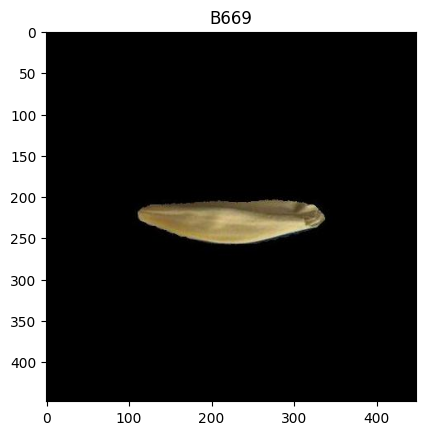

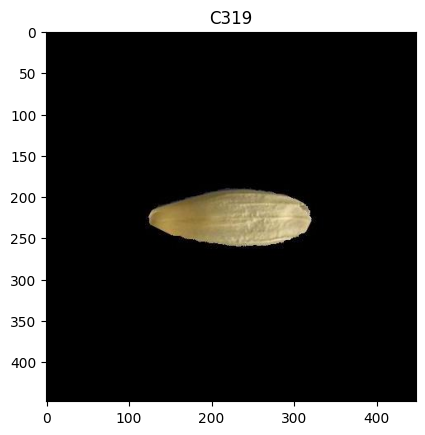

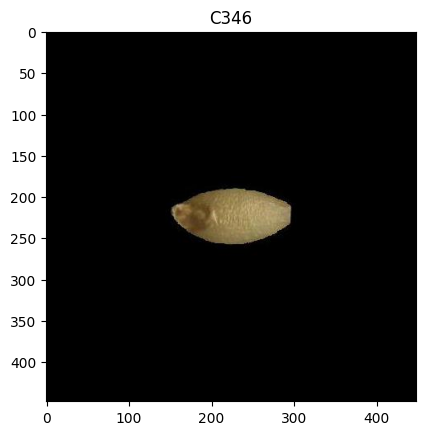

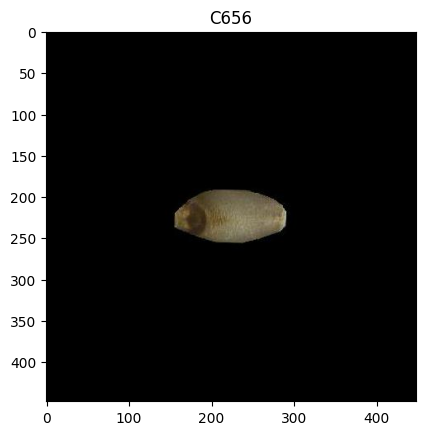

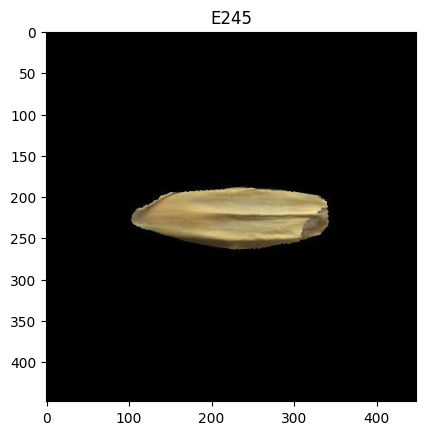

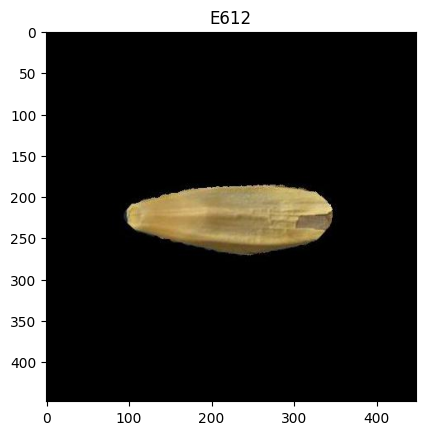

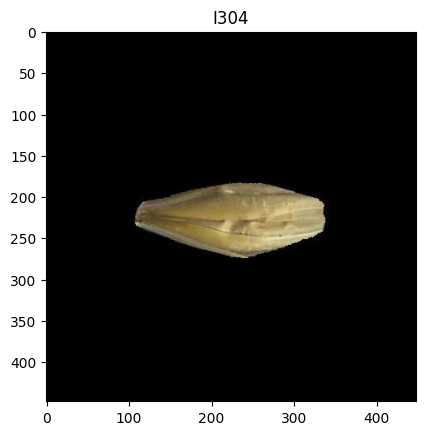

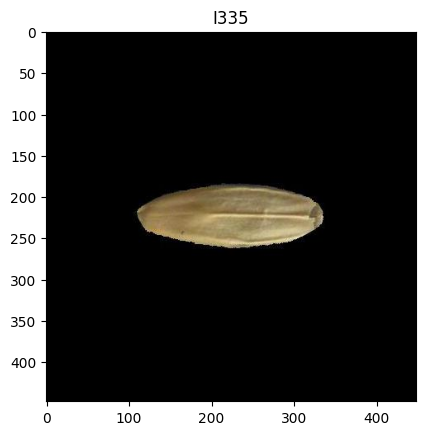

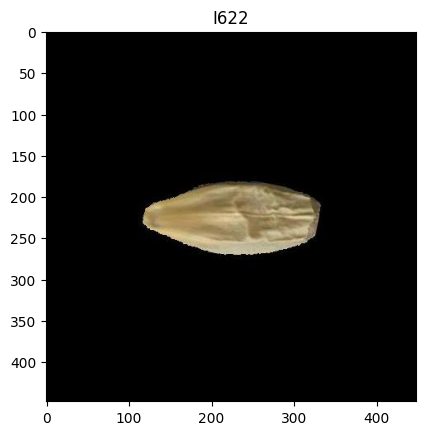

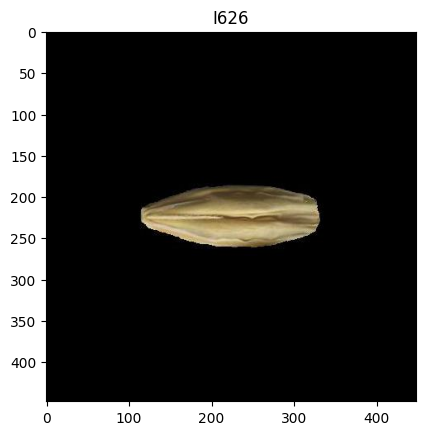

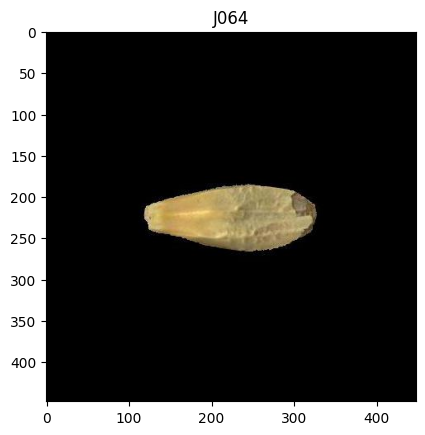

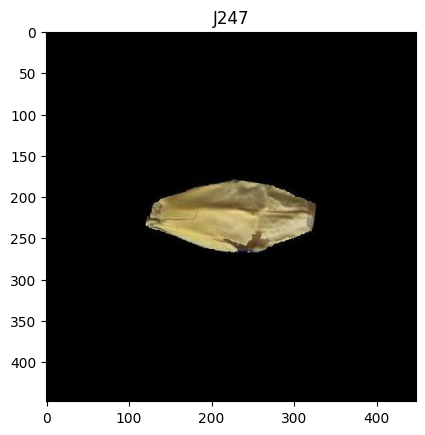

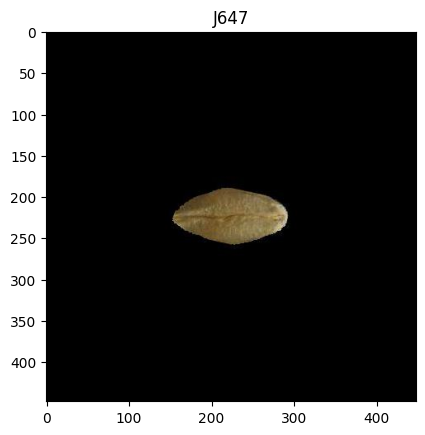

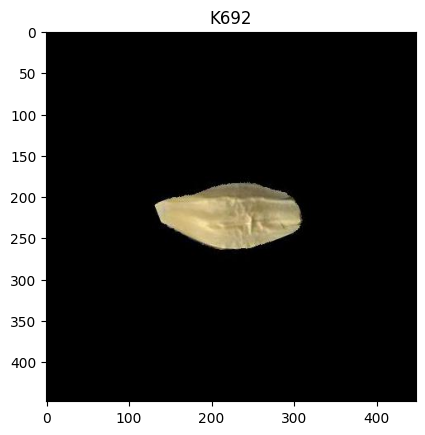

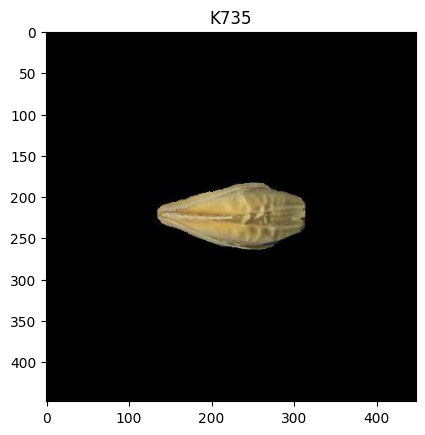

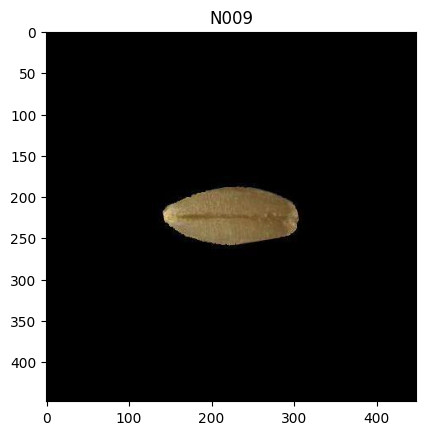

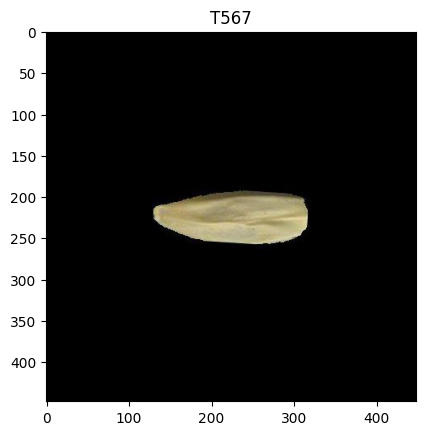

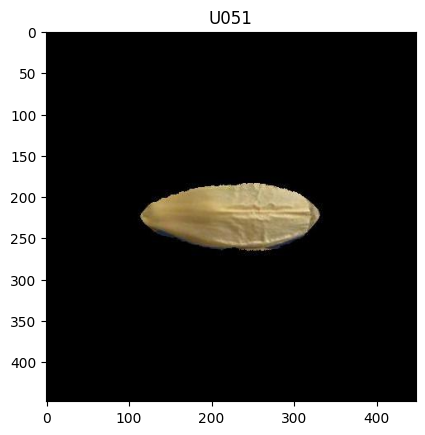

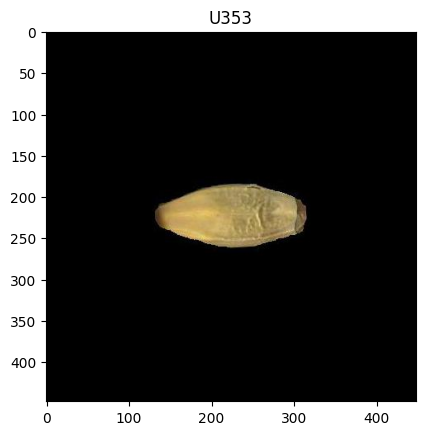

In [ ]:
for folder in folders2:
    files = os.listdir(os.path.join(DATASET_DIR, folder))
    # 最初のファイルだけ表示する。
    file = files[0]
    image = cv2.imread(os.path.join(DATASET_DIR, folder, file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title(folder)
    plt.imshow(image)
    plt.show()


## データセットをtf.kerasで使用できる形に整える


kerasで分類問題を解く深層学習を行うために必要なデータセットのフォーマットは、複数種類あります。今回はその１つである、メモリに入力画像と真値ラベルを全部読み込ませる方法を使います。入力データがxであり、ラベルがyであるとすると、

- xはnumpy arrayであり、その形が(batch, height, width, channel)の形であること

- yはnumpy arrayであり、その形が（batch, num_of_categories）の形であること。

上記２つが必要となります。

例えば画像が100個あり、各々が32x32pxのRGB画像であって、4品種の分類問題を解きたい場合、用意すべきデータの形は
x: (100,32,32,3)
y: (100, 4)

となります。なお、yの4はone-hotな形をしたベクトルであり、後に解説します。

In [ ]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

folders = folders2

In [ ]:
x = []
dense_y = []

for i, folder in enumerate(folders):
    # サブフォルダの絶対パス
    folder_path = os.path.join(DATASET_DIR, folder)
    # サブフォルダにある画像ファイル名を取得
    file_names = os.listdir(folder_path)
    for file_name in file_names:
        # 画像の絶対パス
        image_path = os.path.join(DATASET_DIR, folder, file_name)
        #　画像を読み込む
        image = cv2.imread(image_path)
        # BGRからRGBに色順序を変換する
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # スライスを使い、中心を切り抜く
        image = image[70:370, 70:370, :]
        # 縮小する
        image = cv2.resize(image, (128,128))
        # 画像をxのリストにappendする
        x.append(image)
        dense_y.append(i)

# リストをnumpy形式に変換する
x = np.array(x)
dense_y = np.array(dense_y)

# ｘとyのnumpyのshapeを出力する
print(x.shape)
print(dense_y.shape)

(1315, 128, 128, 3)
(1315,)


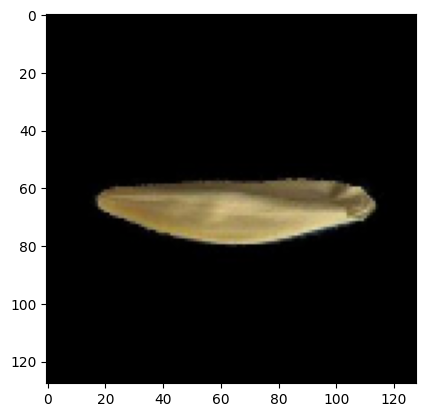

In [ ]:
# xに格納された画像を表示
plt.imshow(x[0])
plt.show()

In [ ]:
# yを one hot 変換する
y = to_categorical(dense_y)
print(dense_y.shape)
print(dense_y)
print(y.shape)
print(y)

(1315,)
[ 0  0  0 ... 18 18 18]
(1315, 19)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
# train, validation, test datasetに分割します。

from sklearn.model_selection import train_test_split

# trainとそれ以外に分割します
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, stratify=np.argmax(y,axis=-1))
# validationとtestに分割します。
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=-1))

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1052, 128, 128, 3) (1052, 19)
(131, 128, 128, 3) (131, 19)
(132, 128, 128, 3) (132, 19)


## ニューラルネットワークモデルの訓練（naive）

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# おまじない。GPUのメモリをクリアする。
tf.keras.backend.clear_session()

model = tf.keras.Sequential(
    [
        layers.Input((128,128,3)),
        layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.GlobalAveragePooling2D(),
        layers.Dense(19, activation="softmax")
    ]
)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss",
                   patience = 8,
                   restore_best_weights=True,
                   start_from_epoch=10)

history = model.fit(
    x_train, y_train,
    batch_size=4,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks = [es]
    )

Epoch 1/100
263/263 [==============================] - 5s 10ms/step - loss: 2.4733 - accuracy: 0.2148 - val_loss: 7.9674 - val_accuracy: 0.0382
Epoch 2/100
263/263 [==============================] - 2s 8ms/step - loss: 2.0980 - accuracy: 0.3222 - val_loss: 10.3122 - val_accuracy: 0.0305
Epoch 3/100
263/263 [==============================] - 2s 8ms/step - loss: 1.8559 - accuracy: 0.4049 - val_loss: 6.2632 - val_accuracy: 0.1603
Epoch 4/100
263/263 [==============================] - 3s 10ms/step - loss: 1.7156 - accuracy: 0.4496 - val_loss: 6.3419 - val_accuracy: 0.1603
Epoch 5/100
263/263 [==============================] - 2s 9ms/step - loss: 1.5975 - accuracy: 0.4743 - val_loss: 5.0616 - val_accuracy: 0.0992
Epoch 6/100
263/263 [==============================] - 2s 8ms/step - loss: 1.4579 - accuracy: 0.5466 - val_loss: 13.7365 - val_accuracy: 0.0687
Epoch 7/100
263/263 [==============================] - 2s 8ms/step - loss: 1.4031 - accuracy: 0.5304 - val_loss: 13.2605 - val_accuracy: 0

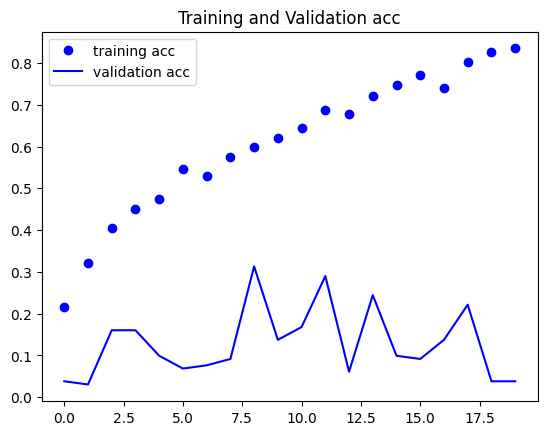

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo' ,label = 'training acc')
plt.plot(epochs, val_acc, 'b' , label= 'validation acc')
plt.title('Training and Validation acc')
plt.legend()

In [ ]:
# チャレンジ
# 上のセルでは精度の他に損失（loss）も計算しています。それをもとにグラフを描画してみましょう。

## 問題を解決して再訓練する

### データ不均衡に対処する

[45, 133, 118, 48, 45, 41, 68, 73, 70, 35, 87, 61, 98, 70, 82, 95, 62, 57, 27]


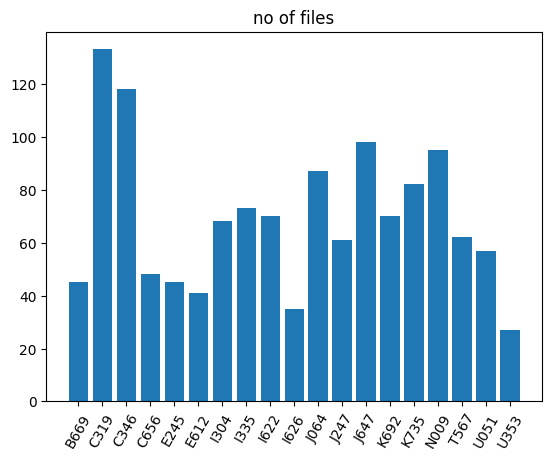

In [ ]:
# 各品種にどれだけの画像枚数があるか確認する。
no_files = []
for folder in folders:
    files = os.listdir(os.path.join(DATASET_DIR, folder))
    no_files.append(len(files))

print(no_files)

plt.bar(folders, no_files)

plt.title("no of files")
plt.xticks(rotation=60);

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

cw = compute_class_weight(class_weight = 'balanced',
                                       classes = np.unique(y_train.argmax(axis=-1)),
                                       y = y_train.argmax(axis=-1))
print(cw)

# kerasが要求する辞書形式に変換する。
keras_cw = dict(enumerate(cw))

print(keras_cw)

[1.5380117  0.52234359 0.58902576 1.45706371 1.5380117  1.67783094
 1.02534113 0.95462795 0.9887218  1.97744361 0.79097744 1.12996778
 0.70985155 0.9887218  0.83891547 0.72853186 1.10736842 1.20366133
 2.51674641]
{0: 1.5380116959064327, 1: 0.522343594836147, 2: 0.5890257558790594, 3: 1.4570637119113574, 4: 1.5380116959064327, 5: 1.6778309409888357, 6: 1.0253411306042886, 7: 0.9546279491833031, 8: 0.9887218045112782, 9: 1.9774436090225564, 10: 0.7909774436090226, 11: 1.129967776584318, 12: 0.7098515519568152, 13: 0.9887218045112782, 14: 0.8389154704944178, 15: 0.7285318559556787, 16: 1.1073684210526316, 17: 1.2036613272311212, 18: 2.5167464114832536}


### 特徴抽出層に学習済モデルの特徴抽出層を使う

In [ ]:
from tensorflow.keras import layers

# おまじない。GPUのメモリをクリアする。
tf.keras.backend.clear_session()

# mobilenetには前処理レイヤーが含まれていることに留意する
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(128,128,3),
                                                    include_top=False,
                                                    weights='imagenet')
model = tf.keras.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(19, activation="softmax")
    ]
)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
es = EarlyStopping(monitor="val_loss",
                   patience = 8,
                   restore_best_weights=True,
                   start_from_epoch=10)


history = model.fit(
    x_train, y_train,
    batch_size=4,
    epochs = 100,
    validation_data = (x_val, y_val),
    class_weight = keras_cw,

    )

Epoch 1/100
263/263 [==============================] - 30s 34ms/step - loss: 2.3690 - accuracy: 0.2719 - val_loss: 3.4986 - val_accuracy: 0.1756
Epoch 2/100
263/263 [==============================] - 6s 24ms/step - loss: 1.6480 - accuracy: 0.4762 - val_loss: 16.1113 - val_accuracy: 0.0916
Epoch 3/100
263/263 [==============================] - 7s 27ms/step - loss: 1.3477 - accuracy: 0.5627 - val_loss: 7.6169 - val_accuracy: 0.1145
Epoch 4/100
263/263 [==============================] - 6s 24ms/step - loss: 1.0691 - accuracy: 0.6502 - val_loss: 7.3125 - val_accuracy: 0.2901
Epoch 5/100
263/263 [==============================] - 7s 27ms/step - loss: 0.9180 - accuracy: 0.7025 - val_loss: 10.8000 - val_accuracy: 0.0840
Epoch 6/100
263/263 [==============================] - 6s 24ms/step - loss: 0.7584 - accuracy: 0.7529 - val_loss: 20.0730 - val_accuracy: 0.1985
Epoch 7/100
263/263 [==============================] - 7s 28ms/step - loss: 0.6435 - accuracy: 0.7833 - val_loss: 11.3635 - val_accu

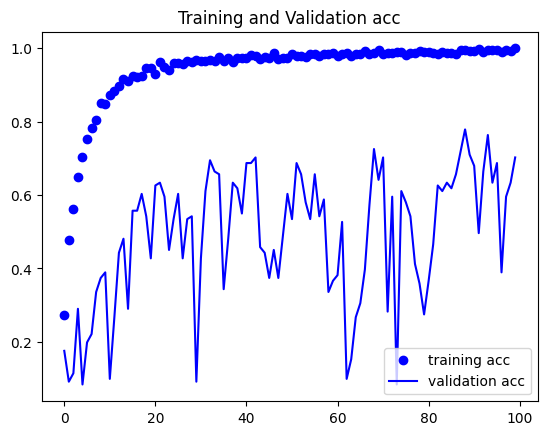

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo' ,label = 'training acc')
plt.plot(epochs, val_acc, 'b' , label= 'validation acc')
plt.title('Training and Validation acc')
plt.legend()

## テストデータセットでのモデルの評価

In [ ]:
# evaluate
model.evaluate(x_test, y_test)

5/5 [==============================] - 0s 11ms/step - loss: 2.3791 - accuracy: 0.7121


[2.3790810108184814, 0.7121211886405945]

In [ ]:
#predict
y_pred_test = model.predict(x_test)

5/5 [==============================] - 2s 16ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(y_pred_test,axis=-1))

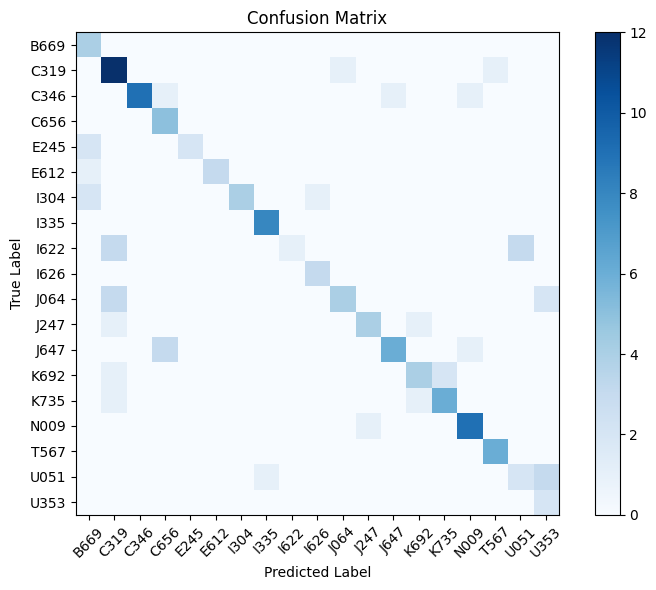

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.xticks(range(len(folders)), folders, rotation=45)
plt.yticks(range(len(folders)), folders)


plt.tight_layout()
plt.show()

# モデルの使い方

In [ ]:
# テストデータから画像とラベルを一対取得します
image = x_test[0]
y_true = np.argmax(y_test[0])

# モデルは通常バッチの次元があるデータを要求します。
# そのままだとshape: (128,128,3)なので、下記のコードを追加して（1,128,128,3）とします
inputs = np.expand_dims(image, axis=0)
# 推論
y_preds = model.predict(inputs)
# 結果もバッチの次元があるので、対応する
y_pred = y_preds[0]
print(y_pred)

# 最も値の高いindex
print("prediction", np.argmax(y_pred))

# 正解ラベル
print("actual label", y_true)


# 正解じゃなかったとしても、正解ラベルに相当するindexの値を見て、数値を確認して突き合わせてみましょう。

1/1 [==============================] - 0s 77ms/step
[5.5177281e-08 2.1085393e-07 9.9981755e-01 9.7335653e-11 3.1374103e-10
 5.2757894e-08 2.8150179e-10 1.9782908e-06 2.2270716e-13 3.3694148e-12
 1.7974262e-04 2.7167888e-09 4.1780027e-07 8.5029617e-10 4.7422817e-09
 5.9696838e-08 3.7531836e-10 3.1908171e-11 6.0331180e-09]
prediction 2
actual label 2
